# Example use of the Signature Simulator
In this demo we will begin by using the Signature Simulator to forward model some Sentinel 1 and 2 backscatters and reflectances. We will then show the Retreival Tool which inverts the Signature Simulator to produce some estimates of Leaf Area Index (LAI), soil moisture and canopy height for a set of fields near Munich, Germany. The tool is available via pip for Python (use the command: `pip install signaturesimulator`) and has a documentation page at [signaturesimulator.readthedocs.io](https://signaturesimulator.readthedocs.io/en/latest/_source/README.html)
## Example 1 - Calculating reflectance and backscatter values for a single aquisition
In this example we will simulate Sentinel 2 reflectance values and Sentinel 1 backscatter values for a given satellite geometry and land surface state. From an interactive console we first import the signaturesimulator package and setup an instance of the Simulator class:

In [35]:
import signaturesimulator as ss
sim = ss.Simulator()

We can now set the viewing geometries and time of the satellite observation, to do this we also need to specify a Python datetime object so we will also import the datetime module:

In [25]:
import datetime as dt  # part of standard Python distribution
sim.get_geom = sim.geom_default(date_utc=dt.datetime(2016,6,17,10,25), vza=5.5, vaa=286.3, sza=26.8, saa=157.0)

Where vza and vaa are the view zenith and azimuth angles and sza and saa are the solar zenith and azimuth angles. We must now specify the land surface state variables for which to calculate Sentinel 2 reflectance values:

In [26]:
sim.get_land_state = sim.state_default(date_utc=dt.datetime(2016,6,17,9,0), lai=3.0, canopy_ht=1.0, soil_m=0.3)

Where lai is leaf are index (m$^2$ m$^{-2}$), canpopy_ht is vegetation canopy height (m) and soil_m is the top layer soil moisture (m$^3$ m$^{-3}$). We now specify the radiative transfer model we want to use and then run the simulator (currently there is the choice between active microwave and passive optical with these models being setup for the Sentinel 1 and 2 missions respectively). Here we are interested in reflectance, so set the following:

In [27]:
sim.run_rt = sim.passive_optical
sim.run()  # Running a canopy radiative transfer model, convolving output with spectral response functions of Sentinel 2

Once the simulator has finished its run it will write the output to a new spectra class. We can then look at the reflectance values for different bands (ordered by wavelength) using the following command:

In [28]:
sim.spectra.refl

[array([0.018664, 0.020378, 0.026745, 0.02097 , 0.035889, 0.213055,
        0.332095, 0.338523, 0.343047, 0.337906, 0.230565, 0.192891,
        0.086688])]

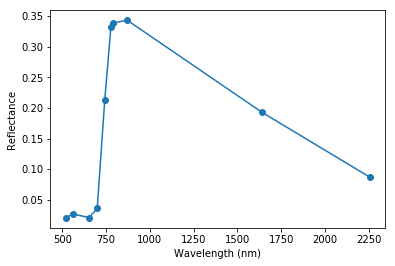

In [29]:
# Plot reflectance by wavelength
import demo
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
wavl = demo.sentinel2_wavl()
refl_sub = np.delete(sim.spectra.refl, [0,9,10])
plt.plot(wavl, refl_sub, 'o-')
plt.xlabel('Wavelength (nm)')
plt.ylabel('Reflectance')
plt.show()

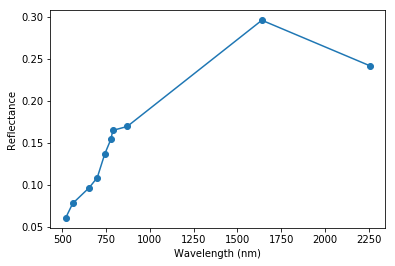

In [30]:
sim.get_land_state = sim.state_default(date_utc=dt.datetime(2016,6,17,9,0), lai=0.2, canopy_ht=0.01, soil_m=0.2)
sim.run_rt = sim.passive_optical
sim.run()
wavl = demo.sentinel2_wavl()
refl_sub = np.delete(sim.spectra.refl, [0,9,10])
plt.plot(wavl, refl_sub, 'o-')
plt.xlabel('Wavelength (nm)')
plt.ylabel('Reflectance')
plt.show()

In the same way we can also produce estimates of backscatter for sentinel 1:

In [31]:
sim = ss.Simulator()
sim.get_geom = sim.geom_default(date_utc=dt.datetime(2016,1,3,5,25), vza=34.37, vaa=100.54, sza=105.29, saa=107.40)
sim.get_land_state = sim.state_default(date_utc=dt.datetime(2016,1,17,9,0), lai=5.2, canopy_ht=1.5, soil_m=0.23)
sim.run_rt = sim.active_microwave
sim.run()
sim.backscat.hv

[0.00341203492278161]

## Using JULES to construct estimates to the land surface state
JULES models the evolution of the land surface given some meteorological forcing data.
![JULES land surface model](jules.png)
In this example we have used JULES to model the evolution of land surface variables for a maize field. The output of the JULES model is a netCDF file containing outputed variables specified in the output.nml file in the directory from which JULES has been run. The `state_jules` function of the Simulator class reads the JULES output and extracts the variables required to forward model reflectance and backscatter. We could use any land surface model we choose to generate these estimates or even field data. Next we show some of the JULES model output.

In [7]:
reload(ss)
sim = ss.Simulator()
sim.get_geom = sim.geom_csv(fname=sim.example_s1_geometries)
sim.get_land_state = sim.state_jules(sim.dir_path+'/data/jules/output/jules_90.daily.nc')
sim.run_rt = sim.active_microwave
sim.run()

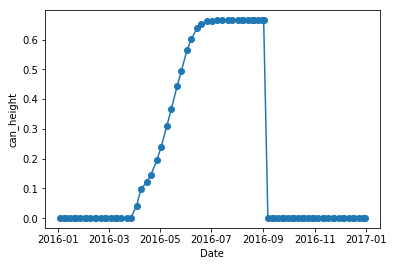

In [11]:
sim.plot('can_height', line_sty='-o')
import matplotlib.pyplot as plt
plt.show()

From this output we can simulate multiple acquisitions for Sentinel 1 and 2 which we can use as prior estimates in the retrieval algorithm.

In the above example `sim.example_s1_geometries` points to an example csv file included with the signaturesimulator package found here:

`
$PYTHONPATH/signaturesimulator/data/geometries/s1_example_const.csv
`

Any geometry csv file must be of the following format:

```
# date, vza, vaa, sza, saa
2016/01/03 05:23,34.3773946043,100.545700717,105.298744327,107.406448412
2016/01/08 05:31,23.4284120953,102.103838392,103.928256857,108.076934788
...
```

We have also run the simulator using the active microwave radiative transfer model `sim.run_rt = sim.active_microwave`. Next we plot the foward modelled backscatter in the hv polarisation. To plot the backscatter in the hv polaristation we can use the following command:

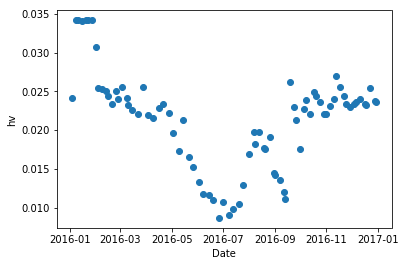

In [13]:
sim.plot('hv')
plt.show()

Here we can see the effect the land surface state is having on backscatter as it changes over time:

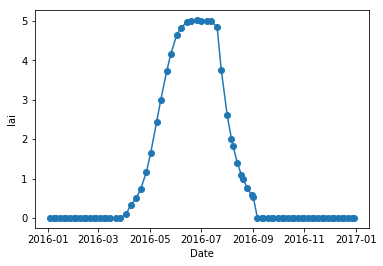

In [12]:
sim.plot('lai', line_sty='-o')
plt.show()

We can also look at the time series values for Sentinel 2 reflectances:

In [33]:
sim = ss.Simulator()
sim.get_geom = sim.geom_csv(fname=sim.example_s2_geometries)
sim.get_land_state = sim.state_jules(sim.dir_path+'/data/jules/output/jules_90.daily.nc')
sim.run_rt = sim.passive_optical
sim.run()

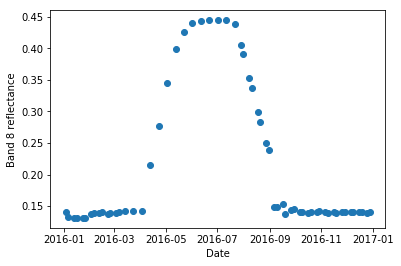

In [15]:
sim.plot('refl', band_idx=7)
plt.show()

We can also use the foward modelled reflectences to calculate vegetation indicies:

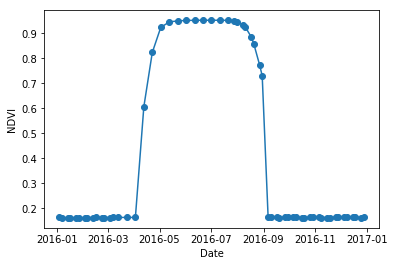

In [34]:
import numpy as np

refl = np.array(sim.spectra.refl)
ndvi = (refl[:, 7]-refl[:, 3])/(refl[:, 7]+refl[:, 3]) # calculate NDVI for crop
# rvi = refl[:, 7]/refl[:, 3] # ratio vegetation index
# ndre = (refl[:, 7]-refl[:, 5])/(refl[:, 7]+refl[:, 5]) # normalised difference red rdge
plt.plot(sim.get_geom.date_utc, ndvi, 'o-')
plt.ylabel('NDVI')
plt.xlabel('Date')
plt.show()

## Finding different estimates to the land surface state
land surface models contain many parameters controlling the behaviour of the model in response to forcing data. By changing parameters we can find some estimates to the uncertainty in the land surface state.

In the following example we show the impact of changing the crop sow date parameter for maize in JULES:

In [20]:
import signaturesimulator as ss
sim_90 = ss.Simulator()
sim_90.get_geom = sim_90.geom_csv(fname=sim_90.example_s2_geometries)
sim_90.get_land_state = sim_90.state_jules(sim_90.dir_path+'/data/jules/output/jules_90.daily.nc') # day 90 crop sow date
sim_90.run_rt = sim_90.passive_optical
sim_90.run()

sim_110 = ss.Simulator()
sim_110.get_geom = sim_110.geom_csv(fname=sim_110.example_s2_geometries)
sim_110.get_land_state = sim_110.state_jules(sim_110.dir_path+'/data/jules/output/jules_110.daily.nc') # day 110 crop sow date
sim_110.run_rt = sim_110.passive_optical
sim_110.run()

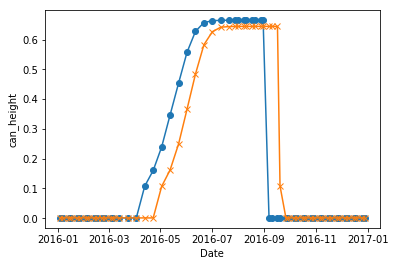

In [21]:
var = 'can_height'
sim_90.plot(var, line_sty='-o')
sim_110.plot(var, line_sty='-x')
plt.show()

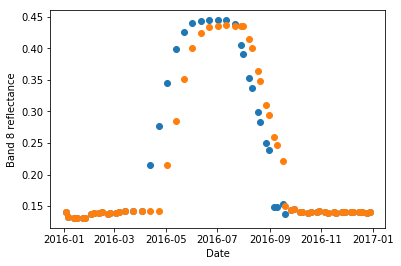

In [56]:
idx = 7
sim_90.plot('refl', band_idx=idx)
sim_110.plot('refl', band_idx=idx)
plt.show()

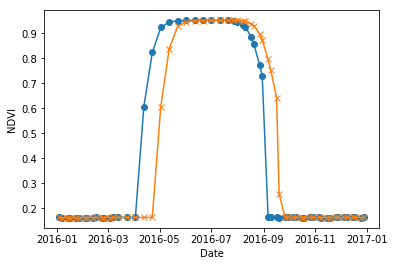

In [48]:
import numpy as np

refl_90 = np.array(sim_90.spectra.refl)
ndvi_90 = (refl_90[:, 7]-refl_90[:, 3])/(refl_90[:, 7]+refl_90[:, 3]) # calculate NDVI for crop sown on 90th day of year
plt.plot(sim_90.get_geom.date_utc, ndvi_90, 'o-')

refl_110 = np.array(sim_110.spectra.refl)
ndvi_110 = (refl_110[:, 7]-refl_110[:, 3])/(refl_110[:, 7]+refl_110[:, 3]) # calculate NDVI for crop sown on 110th day of year
plt.plot(sim_110.get_geom.date_utc, ndvi_110, 'x-')

plt.ylabel('NDVI')
plt.xlabel('Date')
plt.show()